## Generate Word Cloud

In [4]:
!pip install wordcloud

     -------------------------------------- 153.1/153.1 kB 4.6 MB/s eta 0:00:00


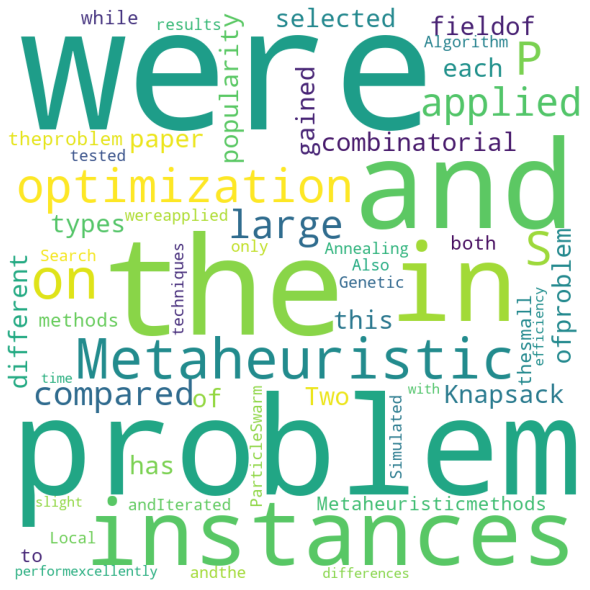

In [6]:
# Import necessary libraries
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Define text to generate word cloud from
#text = "Lorem ipsum dolor sit amet, consectetur adipiscing elit. Donec ac lectus sed massa interdum porttitor vel vel lorem. Sed eleifend euismod libero id pretium. Morbi feugiat tellus et odio ultrices, nec elementum purus imperdiet."
text = "Knapsack problem has gained popularity in the field\
of combinatorial optimization. In this paper, different types of\
problem instances were selected. Two each of S-Metaheuristic\
methods and P-Metaheuristic methods were applied on the\
problem instances. S-Metaheuristics were applied to both the\
small problems and large problems while P-Metaheuristics were\
applied on only the large problems. Simulated Annealing and\
Iterated Local Search were tested on the problem instances and\
the results were compared. Also, Genetic Algorithm and Particle\
Swarm Optimization were compared. The techniques perform\
excellently with slight differences in the efficiency and time."

# Generate word cloud
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = set(), 
                min_font_size = 10).generate(text)

# Plot word cloud
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
# Show plot
plt.show()